In [7]:
import os
import time
import numpy as np
from astropy import wcs
from astropy import constants as cons
from astropy import units as u
from astropy.table import Column
from astropy.io import ascii, fits
from matplotlib import pyplot as plt
import matplotlib as mpl
from astropy.table import Column, Table
from lmfit import minimize, Parameters, Model

mpl.rc("font", family="RomanC", size=12)
mpl.rc("axes", linewidth =  1 )
mpl.rc("lines", linewidth = 1 )
mpl.rc("xtick.major", pad = 8, size = 8, width = 1)
mpl.rc("ytick.major", pad = 8, size = 8, width = 1)
mpl.rc("xtick.minor", size = 4, width = 1 )
mpl.rc("ytick.minor", size = 4, width = 1 )

In [18]:
hmscList = ascii.read('../Tables/hmscFull_20160405.dat')
sedDir = '../fitsDir/sedFitting/allSixMin/'

pixSr = 11.5*11.5*u.arcsec*u.arcsec

wavelengths = np.array([160,250,350, 500, 870]) * u.um
frequencies = wavelengths.to(u.Hz, u.spectral()).value.copy()

errData = np.array([20.0, 20.0, 10.0, 8.0, 8.0])*u.MJy/u.sr
weis = 1.0/errData

# Initiate the parameters
iNh2 = 1.0E+22 # in cm^-2
iTdust = 22.0 # in K.
ibeta = 2.0 # 
betaVary = False # If True, Beta will be fitted.
                 # If False, beta will be fixed.
betaMin = 1.0
betaMax = 3.0

# Constants

h = cons.h.cgs.value   # Planck constant in CGS unit
k = cons.k_B.cgs.value # Boltzmann constant in CGS unit
c = cons.c.cgs.value # speed of light in CGS unit
mH = cons.m_n.cgs.value # mass of an neutron
muh2 = 2.8 # mean molecular weight adopted from Kauffmann et al. (2008)
rGD = 100.0 # gas-to-dust mass ratio
nu0 = 599.584916E9 # Reference frequency in Hz.
kappa0 = 5.0/1.5 # Dust emissivity at reference frequency

def greybody(nu, nH2=iNh2, Tdust=iTdust, beta=ibeta):
    blackBody = 2*h*nu**3/c**2/(np.exp(h*nu/k/Tdust)-1)
    tau = muh2*mH*nH2*kappa0*(nu/nu0)**beta/rGD
    return blackBody*(1-np.exp(-tau))

gMod = Model(greybody)
gMod.set_param_hint('beta', min = betaMin, max = betaMax, 
        vary = betaVary)
gMod.set_param_hint('Tdust',  max = 80.0)

pars = gMod.make_params()

sour  = []
I_160 = []
I_250 = []
I_350 = []
I_500 = []
I_870 = []
Nh2   = []
Tdust = []
betas = []
start = time.time()
pfmt = '%6i %18s %6.2f%% finished.'


for isour in range(len(hmscList)):
    sourName = hmscList['Name'][isour]
    sName    = hmscList['sName'][isour]
    ra_0 = hmscList['ra'][isour]
    dec_0 = hmscList['dec'][isour]
    intensities = []
    for band in ['160', '250', '350', '500', '870']:
        hdus = fits.open(sedDir+sName+'_'+band+'_bgRM.fits')
        xCenter = np.int(hdus[0].header['CRPIX1']-1)
        yCenter = np.int(hdus[0].header['CRPIX2']-1)
        intensities.append(hdus[0].data[yCenter,xCenter])
    
    data = np.array(intensities)*u.MJy/u.sr
    
    if data.value[0]<60:
        sedResult = gMod.fit(data.cgs.value[1:], nu = frequencies[1:],
                             weights = weis.cgs.value[1:])
    else:
        sedResult = gMod.fit(data.cgs.value, nu = frequencies,
                             weights = weis.cgs.value)
    
    sour.append(sourName)
    I_160.append(data.value[0])
    I_250.append(data.value[1])
    I_350.append(data.value[2])
    I_500.append(data.value[3])
    I_870.append(data.value[4])
    Nh2.append(sedResult.params['nH2'].value)
    Tdust.append(sedResult.params['Tdust'].value)
    betas.append(sedResult.params['beta'].value)
    x = np.array(np.logspace(1,3.5, 300))*u.um
    xFreq = x.to(u.Hz, u.spectral()).value.copy()
    outunit=u.erg/u.s/u.cm**2/u.Hz
    y = greybody(xFreq,Tdust = sedResult.params['Tdust'].value,
                nH2= sedResult.params['nH2'].value)*u.g/u.sr/u.s/u.s

    fig1 = plt.figure(1, figsize = (5.5,5.2))
    fig1.subplots_adjust(left = 0.2, right = 0.98, wspace = 0.10,
                         bottom = 0.15, top = 0.96)
    if data.value[0]<60:
        plt.errorbar(wavelengths.value[1:], data.value[1:], yerr = errData.value[1:],
                     fmt = 'o', c = 'black')
    else:
        plt.errorbar(wavelengths.value, data.value, yerr = errData.value,
                     fmt = 'o', c = 'black')
        
    plt.plot(x,y.to(u.MJy/u.sr), '-k')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(4, 200000)
    plt.xlim(8,5000)
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    plt.minorticks_on()
    plt.xlabel('$\lambda$ ($\mu$m)')
    plt.ylabel(r'Intensity (MJy/sr)')
    T    = sedResult.params['Tdust'].value
    errT = sedResult.params['Tdust'].stderr
    B    = sedResult.params['beta'].value
    errB = sedResult.params['beta'].stderr
    N    = sedResult.params['nH2'].value
    errN = sedResult.params['nH2'].stderr
    formatN = '%.2e'%N
    power = np.int(formatN[-2:])
    preNerr = errN/10**power
    label = r"${=\ ("+formatN[:4]+"\pm"+'%.2f'%preNerr+r")\times 10^{"+formatN[-2:]+"}\ cm^{-2}}$"
    
    plt.text(10**(np.log10(xmin)+(np.log(xmax)-np.log(xmin))*0.023), 
             10**(np.log10(ymax)-(np.log(ymax)-np.log(ymin))*0.03), sourName,
             horizontalalignment='left',size = 12)
    plt.text(10**(np.log10(xmin)+(np.log(xmax)-np.log(xmin))*0.023), 
             10**(np.log10(ymax)-(np.log(ymax)-np.log(ymin))*0.055), r"${N_{H_2}}$",
             horizontalalignment='left',size = 12)
    plt.text(10**(np.log10(xmin)+(np.log(xmax)-np.log(xmin))*0.065), 
             10**(np.log10(ymax)-(np.log(ymax)-np.log(ymin))*0.055), label,
             horizontalalignment='left',size = 12)
    label = "${=\ "+'%.2f'%T+"\pm"+'%.2f'%errT+"\ K}$"
    plt.text(10**(np.log10(xmin)+(np.log(xmax)-np.log(xmin))*0.023), 
             10**(np.log10(ymax)-(np.log(ymax)-np.log(ymin))*0.08), "${T_{dust}}$",
             horizontalalignment='left',size = 12)
    plt.text(10**(np.log10(xmin)+(np.log(xmax)-np.log(xmin))*0.065), 
             10**(np.log10(ymax)-(np.log(ymax)-np.log(ymin))*0.08), label,
             horizontalalignment='left',size = 12)
    if pars['beta'].vary == True:
        label = r"${=\ "+'%.2f'%B+"\pm"+'%.2f'%errB+"}$"
    else:
        label = r"${=\ "+'%.1f'%B+"}$"
    plt.text(10**(np.log10(xmin)+(np.log(xmax)-np.log(xmin))*0.023), 
             10**(np.log10(ymax)-(np.log(ymax)-np.log(ymin))*0.105), r"$\beta$",
             horizontalalignment='left',size = 12)
    plt.text(10**(np.log10(xmin)+(np.log(xmax)-np.log(xmin))*0.065), 
             10**(np.log10(ymax)-(np.log(ymax)-np.log(ymin))*0.105), label,
             horizontalalignment='left',size = 12)
    
    
    plt.savefig('../epsFigs/peakSED/'+sourName+'_peakSED.pdf')
    plt.clf()

    print(pfmt %(isour+1, sName, ((isour+1.0) / len(hmscList)*100)))

stop = time.time()
dure = stop - start

print("Run time = ",dure, "seconds")    

peakIntTab = Table([sour, I_160, I_250, I_350, I_500, I_870, Nh2, Tdust],
                  names = ['Name', 'I_160', 'I_250', 'I_350', 'I_500', 
                           'I_870', 'Nh2', 'Tdust'])

     1          G000_0335   0.20% finished.
     2         G000_0355b   0.40% finished.
     3          G000_0474   0.59% finished.
     4          G000_0693   0.79% finished.
     5          G000_0939   0.99% finished.
     6          G000_1150   1.19% finished.
     7          G000_1315   1.38% finished.
     8          G000_2248   1.58% finished.
     9          G000_2386   1.78% finished.
    10          G000_2579   1.98% finished.
    11          G000_2649   2.17% finished.
    12          G000_2670   2.37% finished.
    13          G000_2727   2.57% finished.
    14          G000_2836   2.77% finished.
    15          G000_2960   2.96% finished.
    16          G000_3069   3.16% finished.
    17          G000_3149   3.36% finished.
    18          G000_3173   3.56% finished.
    19          G000_3322   3.75% finished.
    20          G000_3404   3.95% finished.
    21          G000_3550   4.15% finished.
    22          G000_3659   4.35% finished.
    23          G000_3806   4.55

In [9]:
data.value

array([ 6924.06100478,  4797.84135108,  2220.58425969,   740.07484786,
         161.6551823 ])

In [10]:
peakIntTab.write('../Tables/peakIntensity_and_SED_beta2_20161218.txt',
                format = 'ascii.ipac')

In [12]:
peak1_5 = ascii.read('../Tables/peakIntensity_and_SED_beta1_5_20161207.txt')
peak1_5['Nh2'] = peak1_5['Nh2']*1.5
peak1_5.write('../Tables/peakIntensity_and_SED_beta1_5_20161208.txt',
             format = 'ascii.ipac')

In [13]:
peak2_5 = ascii.read('../Tables/peakIntensity_and_SED_beta2_5_20161207.txt')
peak2_5['Nh2'] = peak2_5['Nh2']*1.5
peak2_5.write('../Tables/peakIntensity_and_SED_beta2_5_20161208.txt',
             format = 'ascii.ipac')

In [15]:
%matplotlib inline

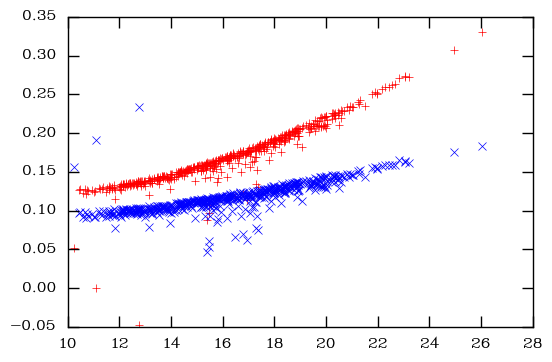

In [16]:
plt.plot(peakIntTab['Tdust'], (peak1_5['Tdust']-peakIntTab['Tdust'])/peakIntTab['Tdust'], '+r')
plt.plot(peakIntTab['Tdust'], (peakIntTab['Tdust']-peak2_5['Tdust'])/peakIntTab['Tdust'], 'xb')

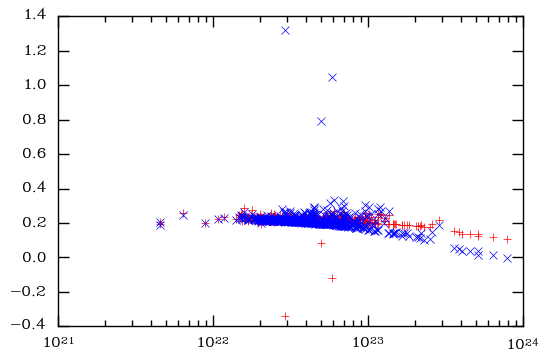

In [17]:
plt.plot(peakIntTab['Nh2'], (peakIntTab['Nh2']-peak1_5['Nh2'])/peakIntTab['Nh2'], '+r')
plt.plot(peakIntTab['Nh2'], (peak2_5['Nh2']-peakIntTab['Nh2'])/peakIntTab['Nh2'], 'xb')
plt.xscale('log')

In [54]:
print(peakIntTab[peakIntTab['Tdust']<10])

      Name           I_160      ...        Nh2            Tdust    
---------------- -------------- ... ----------------- -------------
G014.3848-0.1308  -2.5716648062 ... 6.41854840057e+22  9.5692352806
G347.6783+0.2039 -29.9941001725 ... 9.04845492688e+22 9.90869540365
